## Read in cuisine data

In [2]:
import pandas as pd
import numpy as np
import os


cuisines = pd.read_csv('cuisinedata\cuisine_data.csv', index_col = 'id')

# convert cooking time to minutes
cuisines['timeMins'] = cuisines.totalTimeInSeconds.apply(lambda x: x/60) 
cuisines.drop(['Unnamed: 0'], axis=1, inplace=True)

# convert ingredients from str to list
ingred = cuisines['ingredients'].values
ingredlist = []
for i in range(0, len(ingred)):
    ingredlist.append([x.strip() for x in ingred[i][1:-1].split(',')])
cuisines['ingredients']= ingredlist

# store ingredient count for each recipe
ingredcount = []
for i in range(0, len(ingredlist)):
    ingredcount.append(len(ingredlist[i]))
cuisines['ingred_count'] = ingredcount

# fill in missing courses
cuisines.course.fillna('Unknown', inplace=True)

In [5]:
# drop duplicates
cuisines = cuisines[cuisines.index.duplicated() == False]

## functions to generate a cuisine-specific dataframe for analysis

cuisineslist = ['american', 'italian', 'asian', 'mexican', 'southern', 'french', 'southwestern', 'barbecue', 'indian', 'chinese', 'cajun', 'mediterranean', 'greek', 'english', 'spanish', 'thai', 'german', 'moroccan', 'irish', 'japanese', 'cuban','hawaiian', 'swedish', 'hungarian', 'portuguese']

courselist = ['Main Dishes', 'Desserts', 'Side Dishes', 'Lunch and Snacks', 'Appetizers', 'Salads', 'Breakfast and Brunch', 'Breads', 'Soups', 'Beverages', 'Condiments and Sauces', 'Cocktails']

# function: generate a new dataframe filtered by cuisine
def cuisine_df_generator(cuis):
    cuisdf = cuisines[cuisines.cuisine.str.contains(cuis, case=False)].copy()
    return cuisdf

# function: inspect ratings
def cuisine_ratings(cuisdf):   
    print 'rating distribution: \n', cuisdf.rating.value_counts(), '\n\n', cuisdf.rating.describe(), '\n'

cuisine_ratings(cuisines)

# function: inspect cooking times
def cuisine_times(cuisdf): 
    print 'cooking time in mins: \n', cuisdf.timeMins.describe()
    
cuisine_times(cuisines)

rating distribution: 
4    4988
3    1517
5    1379
0     106
2      44
1       3
Name: rating, dtype: int64 

count    8037.000000
mean        3.918004
std         0.768092
min         0.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64 

cooking time in mins: 
count    7733.000000
mean       64.672701
std       105.188347
min         1.000000
25%        25.000000
50%        40.000000
75%        65.000000
max      1970.000000
Name: timeMins, dtype: float64


In [6]:
# function: inspect cuisine distribution
def cuisine_cuisines(cuisdf):
    cuisine_counts = [] 
    for cuisine in cuisineslist:
        counter = 0
        for i in range(0, len(cuisdf.cuisine.value_counts())):
            if cuisine in cuisdf.cuisine.value_counts().index[i].lower():
                counter += cuisdf.cuisine.value_counts().values[i]
        cuisine_counts.append(counter)
    return dict(zip(cuisineslist, cuisine_counts))

cuisine_cuisines(cuisines)

# function: inspect count, avg time, and avg ingredients of courses
def cuisine_courses(cuisdf):
    course_counts = []    
    for course in courselist:
        print 'Count of ' + course + ': ' + str(len(cuisdf[cuisdf['course'].str.contains(course)]))
        course_counts.append(len(cuisdf[cuisdf['course'].str.contains(course)]))
        print 'Avg time in mins for ' + course + ': ' + str(cuisdf[cuisdf['course'].str.contains(course)].timeMins.mean())
        print 'Avg # of ingreds for ' + course + ': ' + str(cuisdf[cuisdf['course'].str.contains(course)].ingred_count.mean()) + '\n'
    return dict(zip(courselist, course_counts))

# function: inspect recipes based on number of ingredients
def cuisine_ingredients(cuisdf):
    print 'Ingredient distribution: \n', cuisdf.ingred_count.describe(), '\n'
    print 'Fewest ingredients: \n', cuisdf.sort('ingred_count')['ingred_count'].head(5), '\n'
    print 'Most ingredients: \n', cuisdf.sort('ingred_count')['ingred_count'].tail(5)

cuisine_ingredients(cuisines)

# function: inspect ingredient frequency (# of recipes with that ingredient/# of recipes overall)
def cuisine_unique_ingredients(cuisdf):
    cuis_ingredients = []
    for i in range(0, len(cuisdf.ingredients)):
        cuis_ingredients += list(cuisdf.ingredients[i])
    cuis_ingredients = pd.DataFrame(cuis_ingredients, columns=['instances'])
    cuis_unique_ingreds = pd.DataFrame(cuis_ingredients['instances'].value_counts(), columns=['instances'])
    cuis_unique_ingreds['frequency'] = cuis_unique_ingreds['instances']/len(cuisdf)
    return cuis_unique_ingreds

cuisine_unique_ingredients(cuisine_df_generator('thai'))

# function: calculate 2 uniqueness scores for each recipe WITHIN a cuisine
def cuisine_uniqueness(cuis):
    cuisdf = cuisine_df_generator(cuis)
    cuis_unique_ingreds = cuisine_unique_ingredients(cuisine_df_generator(cuis))
    uniq_score= []
    uniq_score2= []
    for i in range(0,len(cuisdf)):
        frequency_score = 0
        container = []
        for ingredient in cuisdf.iloc[i]['ingredients']:
            frequency_score += cuis_unique_ingreds.ix[ingredient]['frequency']
            container.append(cuis_unique_ingreds.ix[ingredient]['frequency'])
        uniq_score.append((frequency_score/cuisdf.iloc[i]['ingred_count'])*100)
        uniq_score2.append(np.product(container))
    cuisdf['uniq_score'] = uniq_score
    cuisdf['uniq_score2'] = uniq_score2
    return cuisdf


Ingredient distribution: 
count    8037.000000
mean       10.146199
std         4.350715
min         2.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        35.000000
Name: ingred_count, dtype: float64 

Fewest ingredients: 
id
Chocolate-Panini-Real-Simple-199065     2
German-Applesauce-1299137               2
Ratatouille-with-Eggs-Martha-Stewart    2
Edamame-Martha-Stewart-194809           2
Grilled-Barbeque-Chicken-1371395        2
Name: ingred_count, dtype: int64 

Most ingredients: 
id
The-Mexican-Bowl-1363648                                                       32
Scrambled-Eggs-With-Spice-studded-Rice-1369721                                 33
Chana-Masala-Waffles-with-Samosa-Potatoes-and-Cilantro-Mint-Chutney-1368231    34
Chicken-Biriyani-1369281                                                       35
Thai-Chicken-Tacos-_with-Bean-Sprout-Slaw-_-Peanut-Sauce_-1325442              35
Name: ingred_count, dtype: int64


C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [7]:
## dataframe for further analysis
italian = cuisine_uniqueness('italian')

# most unique and least unique Main Dishes
print 'Most unique :'
print italian[italian['course'].str.contains('Main Dishes')].sort_values(by='uniq_score')[['uniq_score', 'ingredients']].head(4)

Most unique :
                                                    uniq_score  \
id                                                               
Ravioli-with-Italian-Cheese-_-Herb-Cream-Sauce_...    0.712251   
Pasta-fagioli-297028                                  0.769231   
Spicy-Italian-Crescent-Ring-772394                    0.976801   
Goat-cheese-_-roasted-red-pepper-panini-297357        1.032764   

                                                                                          ingredients  
id                                                                                                     
Ravioli-with-Italian-Cheese-_-Herb-Cream-Sauce_...  [Italian cheese, cheese ravioli, sun-dried tom...  
Pasta-fagioli-297028                                [chunky pasta sauce, white kidney beans, froze...  
Spicy-Italian-Crescent-Ring-772394                  [Pillsbury™ Refrigerated Crescent Dinner Rolls...  
Goat-cheese-_-roasted-red-pepper-panini-297357      [bread, goat chee

In [8]:
# other dataframe inspections / sandbox:
len(cuisines)
cuisine_unique_ingredients(cuisines)
cuisines.columns
cuisine_cuisines(cuisines)

cuisines.sort('ingred_count').head(20)
cuisines.ix['Grilled-BBQ-Zucchini-1371766']

cuisines.timeMins.value_counts()
cuisines.dropna().sort('timeMins').tail(30)


C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients,timeMins,ingred_count
id,,,,,,,,
Crock-Pot-Cuban-Pulled-Pork-1100915,Crock Pot Cuban Pulled Pork,4,44100.0,[Main Dishes],[Cuban],"[pork shoulder roast, lime, sour orange juice,...",735.0,12
Moroccan-Spiced-Grilled-Lamb-Wraps-1282601,Moroccan-Spiced Grilled Lamb Wraps,4,44700.0,[Main Dishes],[Barbecue],"[leg of lamb, salt, ground black pepper, lemon...",745.0,16
Awesome-Korean-Steak-Allrecipes,Awesome Korean Steak,5,45000.0,[Main Dishes],[Asian],"[fillets, soy sauce, white sugar, sesame seeds...",750.0,8
BBQ-Char-Siu-on-the-Grill-1206872,BBQ Char Siu on the Grill,4,45300.0,[Main Dishes],"[Barbecue, Asian]","[boneless pork shoulder, sugar, salt, chinese ...",755.0,15
Chicken-Portuguese-Style-_galinha-De-Vinha-D_ahlos_-Recipezaar,Chicken Portuguese Style (Galinha De Vinha D'a...,3,46800.0,[Main Dishes],[Portuguese],"[chicken thighs, white vinegar, salt, hot pepp...",780.0,9
Blazing-Brisket-Allrecipes,Blazing Brisket,4,46800.0,[Main Dishes],[Hungarian],"[beef brisket, bacon, brewed coffee, salt, but...",780.0,11
Red-Beans-Creole-1249126,Red Beans Creole,3,48300.0,[],[Cajun & Creole],"[red beans, water, chopped onion, sliced mushr...",805.0,10
Cuban-Black-Beans-I-Allrecipes,Cuban Black Beans I,4,49800.0,Unknown,[Cuban],"[black beans, onions, red bell pepper, green b...",830.0,13
Portuguese-Beef-_-Cacoila-Allrecipes,Portuguese Beef - Cacoila,4,50400.0,[Main Dishes],[Portuguese],"[beef stew meat, orange, white wine, hot peppe...",840.0,10


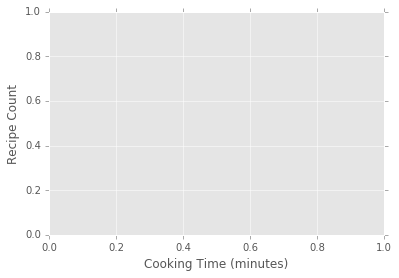

In [9]:
## visualization

import matplotlib.pyplot as plt
import matplotlib.axes as ax
%matplotlib inline

plt.style.available
plt.style.use('ggplot')
plt.xlabel('Cooking Time (minutes)')
plt.ylabel('Recipe Count')

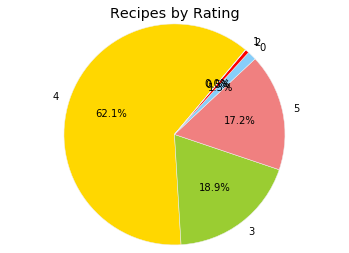

In [10]:
labels = ['4', '3', '5', '0', '2', '1']
plt.pie(cuisines.rating.value_counts(), labels=labels, autopct='%1.1f%%', colors=['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red'], startangle=50, pctdistance=0.6)
plt.axis('equal')
plt.title('Recipes by Rating')
plt.show()

Count of Main Dishes: 3344
Avg time in mins for Main Dishes: 78.384319162
Avg # of ingreds for Main Dishes: 11.9392942584

Count of Desserts: 642
Avg time in mins for Desserts: 79.4603709949
Avg # of ingreds for Desserts: 7.3800623053

Count of Side Dishes: 609
Avg time in mins for Side Dishes: 48.828125
Avg # of ingreds for Side Dishes: 7.88177339901

Count of Lunch and Snacks: 437
Avg time in mins for Lunch and Snacks: 53.0648379052
Avg # of ingreds for Lunch and Snacks: 7.75743707094

Count of Appetizers: 543
Avg time in mins for Appetizers: 49.7607003891
Avg # of ingreds for Appetizers: 8.81399631676

Count of Salads: 480
Avg time in mins for Salads: 35.5553191489
Avg # of ingreds for Salads: 10.1104166667

Count of Breakfast and Brunch: 247
Avg time in mins for Breakfast and Brunch: 49.864628821
Avg # of ingreds for Breakfast and Brunch: 7.91902834008

Count of Breads: 291
Avg time in mins for Breads: 93.0729927007
Avg # of ingreds for Breads: 8.07216494845

Count of Soups: 534
Av

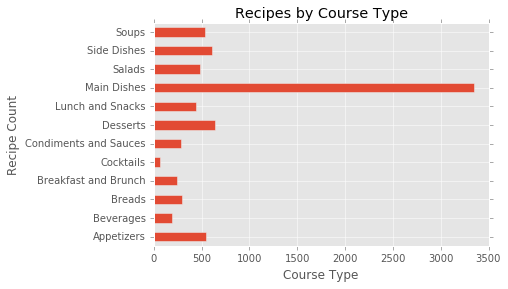

In [11]:
course_data = pd.Series(cuisine_courses(cuisines))
course_data.plot(kind='barh')
plt.xlabel('Course Type')
plt.ylabel('Recipe Count')
plt.title('Recipes by Course Type')
plt.show()

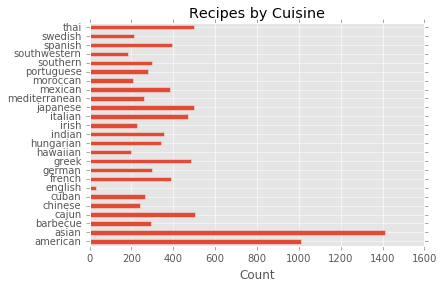

In [13]:
cuisine_cuisines(cuisines)
pd.Series(cuisine_cuisines(cuisines)).plot(kind='barh')
plt.xlabel('Count')
plt.title('Recipes by Cuisine')
plt.show()

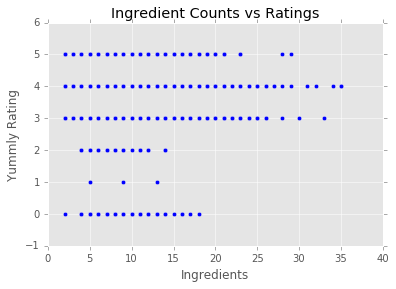

In [14]:
## relationships?

# ingredient/rating relationship?
import numpy as np
feature_cols = ['ingred_count']
X= cuisines[feature_cols]
y= cuisines.rating
plt.scatter(X, y)
plt.xlabel('Ingredients')
plt.ylabel('Yummly Rating')
plt.title('Ingredient Counts vs Ratings')
plt.show()

In [15]:
from sklearn.linear_model import LinearRegression
linreg= LinearRegression()
linreg.fit(X, y)
linreg.intercept_
linreg.coef_
linreg.score(X, y)

0.0029100600636868812

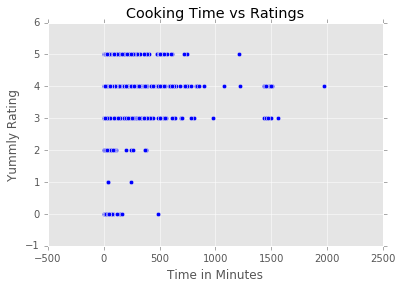

In [16]:
# cooking time/rating relationship?
feature_cols = ['timeMins']
X= cuisines.dropna()[feature_cols]
y= cuisines.dropna().rating
plt.scatter(X, y)
plt.xlabel('Time in Minutes')
plt.ylabel('Yummly Rating')
plt.title('Cooking Time vs Ratings')
plt.show()

In [17]:
linreg= LinearRegression()
linreg.fit(X, y)
linreg.intercept_
linreg.coef_
linreg.score(X, y)

2.3152846904128666e-06

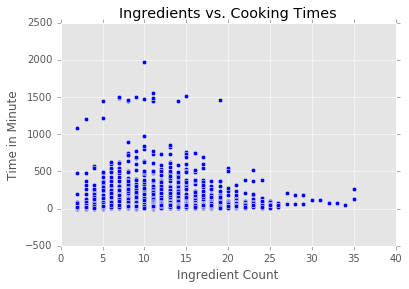

In [18]:
# ingredients/cooking time relationship?
feature_cols = ['ingred_count']
X= cuisines.dropna()[feature_cols]
y= cuisines.dropna()['timeMins']
plt.scatter(X, y)
plt.xlabel('Ingredient Count')
plt.ylabel('Time in Minute')
plt.title('Ingredients vs. Cooking Times')
plt.show()

In [19]:
linreg= LinearRegression()
linreg.fit(X, y)
linreg.intercept_
linreg.coef_
linreg.score(X, y)

0.006031425918799016

In [20]:
## cuisine predictor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split

In [21]:
# convert ingredients back into strings
ingredients_str = []
for i in cuisines.ingredients:
    ingredients_str.append(' '.join(i))
cuisines['ingred_str'] = ingredients_str

In [22]:
# convert cuisine types to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisines.cuisine)
cuisines['cuisine_label'] = le.transform(cuisines.cuisine)

In [115]:
# train/test/split bag of words with Multinomial NB
feature_cols = 'ingred_str'
X = cuisines[feature_cols]
y = cuisines.cuisine_label

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size = 0.2)

In [117]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [26]:
vect.vocabulary_

{u'stock': 1710,
 u'all': 22,
 u'sicilian': 1608,
 u'gai': 707,
 u'chinese': 341,
 u'unflavored': 1855,
 u'mackerel': 1038,
 u'ale': 20,
 u'yellow': 1950,
 u'four': 675,
 u'island': 885,
 u'asian': 64,
 u'parmesan': 1248,
 u'bucatini': 219,
 u'onions': 1207,
 u'porcini': 1363,
 u'chowchow': 362,
 u'preserves': 1386,
 u'canes': 262,
 u'beaters': 111,
 u'sparkling': 1667,
 u'sashimi': 1531,
 u'pancetta': 1237,
 u'granola': 763,
 u'dairy': 509,
 u'preserved': 1385,
 u'dressing': 563,
 u'nori': 1184,
 u'cress': 460,
 u'manis': 1054,
 u'turnips': 1841,
 u'premium': 1382,
 u'bruschetta': 217,
 u'deli': 525,
 u'rise': 1469,
 u'verbena': 1881,
 u'fat': 618,
 u'baton': 102,
 u'vera': 1880,
 u'romain': 1485,
 u'jack': 889,
 u'softened': 1649,
 u'veri': 1883,
 u'hemp': 837,
 u'ramen': 1430,
 u'fresca': 685,
 u'sichuan': 1607,
 u'caramels': 273,
 u'baking': 83,
 u'broiler': 211,
 u'wholemeal': 1928,
 u'large': 972,
 u'solid': 1650,
 u'prosciutto': 1393,
 u'poblano': 1350,
 u'moulard': 1146,
 u'cho

In [27]:
f=vect.inverse_transform(X_train_dtm)
f

[array([u'oil', u'onions', u'tomatoes', u'green', u'chile', u'pepper',
        u'salt', u'cumin', u'large', u'eggs', u'shredded', u'lettuce',
        u'cheese', u'chopped', u'cilantro', u'olive', u'spray', u'corn',
        u'tortillas'], 
       dtype='<U15'),
 array([u'oil', u'pepper', u'salt', u'corn', u'egg', u'noodles', u'chicken',
        u'breasts', u'garlic', u'cabbage', u'carrots', u'oyster', u'sauce',
        u'soy', u'dark', u'sugar', u'sesame', u'water', u'white',
        u'beansprouts', u'scallions', u'baking', u'soda', u'starch'], 
       dtype='<U15'),
 array([u'oil', u'pepper', u'salt', u'cilantro', u'garlic', u'sauce',
        u'soy', u'dark', u'sesame', u'water', u'swordfish', u'fillets',
        u'sea', u'ground', u'black', u'red', u'sweet', u'onion',
        u'pineapple', u'lime', u'crimini', u'mushrooms', u'crushed',
        u'ginger', u'juice', u'orange', u'lemon', u'unsweetened',
        u'coconut', u'milk', u'dijon', u'mustard', u'hoisin', u'reduced',
        u's

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.542910447761


In [29]:
# train/test/split with Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_logreg_pred_class = logreg.predict(X_test_dtm)
print metrics.accuracy_score(y_test, y_logreg_pred_class)

0.444029850746


In [30]:
len(cuisines.cuisine.value_counts())

206

# Advancements made to the above code

## ->Applying random Forest classifier

In [33]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train_dtm, y_train)
y_rf_pred_class = rf.predict(X_test_dtm)
print metrics.accuracy_score(y_test, y_rf_pred_class)

0.517412935323


## ->Applying K-Nearest Neighbours classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = [1, 3, 5, 7, 9, 11, 13]
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors= k, C = 100, gamma = 0.01)
    knn.fit(X_train_dtm,y_train)
    y_knn = knn.predict(X_test_dtm)
    print metrics.accuracy_score(y_test, y_knn)

C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


0.421019900498
0.386815920398
0.416666666667
0.432213930348
0.427860696517
0.434701492537
0.437810945274


## ->Applying K-Fold Cross Validation

In [35]:
from sklearn.cross_validation import KFold, cross_val_score

In [36]:
X.shape

(8037L,)

### --> For Cuisines

In [37]:
yy = cuisines.cuisine_label
nb1 = MultinomialNB()
vectorizer = CountVectorizer()
xtr_dtm = vectorizer.fit_transform(X)
scores = cross_val_score(nb1, xtr_dtm, yy, cv = KFold(n = 8037, shuffle = True, n_folds = 100))
scores.mean()

0.55944753086419763

### ->For Recipes

In [118]:
# convert recitpe types to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisines.recipeName)
cuisines['recipe_label'] = le.transform(cuisines.recipeName)

# train/test/split bag of words with Multinomial NB
feature_cols = 'ingred_str'
X = cuisines[feature_cols]
y = cuisines.recipe_label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size = 0.2)

vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

vect.vocabulary_

{u'stock': 1710,
 u'all': 22,
 u'sicilian': 1608,
 u'gai': 707,
 u'chinese': 341,
 u'unflavored': 1855,
 u'mackerel': 1038,
 u'ale': 20,
 u'yellow': 1950,
 u'four': 675,
 u'island': 885,
 u'asian': 64,
 u'parmesan': 1248,
 u'bucatini': 219,
 u'onions': 1207,
 u'porcini': 1363,
 u'chowchow': 362,
 u'preserves': 1386,
 u'canes': 262,
 u'beaters': 111,
 u'sparkling': 1667,
 u'sashimi': 1531,
 u'pancetta': 1237,
 u'granola': 763,
 u'dairy': 509,
 u'preserved': 1385,
 u'dressing': 563,
 u'nori': 1184,
 u'cress': 460,
 u'manis': 1054,
 u'turnips': 1841,
 u'premium': 1382,
 u'bruschetta': 217,
 u'deli': 525,
 u'rise': 1469,
 u'verbena': 1881,
 u'fat': 618,
 u'baton': 102,
 u'vera': 1880,
 u'romain': 1485,
 u'jack': 889,
 u'softened': 1649,
 u'veri': 1883,
 u'hemp': 837,
 u'ramen': 1430,
 u'fresca': 685,
 u'sichuan': 1607,
 u'caramels': 273,
 u'baking': 83,
 u'broiler': 211,
 u'wholemeal': 1928,
 u'large': 972,
 u'solid': 1650,
 u'prosciutto': 1393,
 u'poblano': 1350,
 u'moulard': 1146,
 u'cho

In [39]:
f=vect.inverse_transform(X_train_dtm)
f

[array([u'oil', u'onions', u'tomatoes', u'green', u'chile', u'pepper',
        u'salt', u'cumin', u'large', u'eggs', u'shredded', u'lettuce',
        u'cheese', u'chopped', u'cilantro', u'olive', u'spray', u'corn',
        u'tortillas'], 
       dtype='<U15'),
 array([u'oil', u'pepper', u'salt', u'corn', u'egg', u'noodles', u'chicken',
        u'breasts', u'garlic', u'cabbage', u'carrots', u'oyster', u'sauce',
        u'soy', u'dark', u'sugar', u'sesame', u'water', u'white',
        u'beansprouts', u'scallions', u'baking', u'soda', u'starch'], 
       dtype='<U15'),
 array([u'oil', u'pepper', u'salt', u'cilantro', u'garlic', u'sauce',
        u'soy', u'dark', u'sesame', u'water', u'swordfish', u'fillets',
        u'sea', u'ground', u'black', u'red', u'sweet', u'onion',
        u'pineapple', u'lime', u'crimini', u'mushrooms', u'crushed',
        u'ginger', u'juice', u'orange', u'lemon', u'unsweetened',
        u'coconut', u'milk', u'dijon', u'mustard', u'hoisin', u'reduced',
        u's

In [119]:
yy = cuisines.recipe_label
nb1 = MultinomialNB()
vectorizer = CountVectorizer()
xtr_dtm = vectorizer.fit_transform(X)
scores = cross_val_score(nb1, xtr_dtm, yy, cv = KFold(n = 8037, shuffle = True, n_folds = 100))
scores.mean()

0.032104938271604939

In [33]:
cuisines.head()

,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients,timeMins,ingred_count,ingred_str,cuisine_label
id,,,,,,,,,,
Southern-Cornbread-Dressing-1357820,Southern Cornbread Dressing,4,3600.0,Unknown,[Southern & Soul Food],"[buttermilk cornbread, sandwich bread, salt, b...",60.0,11,buttermilk cornbread sandwich bread salt black...,174
Peanut-butter-fudge-297693,Peanut Butter Fudge,4,8100.0,[Desserts],[American],"[Country Crock® Spread, light corn syrup, crea...",135.0,5,Country Crock® Spread light corn syrup creamy ...,28
Buckeyes-298471,Buckeyes,4,6600.0,[Desserts],[American],"[Skippy® Super Chunk® Peanut Butter, Country C...",110.0,4,Skippy® Super Chunk® Peanut Butter Country Cro...,28
Disappearing-buffalo-chicken-dip-297712,Disappearing Buffalo Chicken Dip,4,2100.0,[Appetizers],[American],"[light mayonnaise, lemon juice, cayenne pepper...",35.0,7,light mayonnaise lemon juice cayenne pepper sa...,28
Classic-macaroni-salad-304692,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]",[American],"[elbow macaroni, hellmann' or best food real m...",25.0,13,elbow macaroni hellmann' or best food real may...,28


## Find recipes that you can make given a set of supplies in the pantry

In [41]:
# find number of possible recipes
pantry = cuisine_unique_ingredients(cuisines).index[0:100]

In [44]:
def what_can_I_make():    
    cuisines['possible'] = False
    for i, row in cuisines.iterrows():
        possible = False
        if set(row.ingredients).issubset(set(pantry)):
            possible = True
            print row.recipeName
        cuisines.set_value(i, 'possible', possible)
    return cuisines.possible.value_counts()

In [45]:
what_can_I_make()

Hash Browns
Popovers
Simple Syrup
Caramelized Onions
Honey Limeade
Southern Fried Chicken
Limeade
Caramel Sauce
Roasted Quartered Chicken and Shallots
Carne Asada Marinade
Fresh Tomato Salsa
Paris, Part Deux
Simple Syrup
Glazed Lemon Pound Cake
Pan Gravy
Avocado Ice Cream
Roasted Garlic
Unagi Sauce
Grilled Potatoes
Cajun Potato Latkes
Chinese Steamed Eggs
Simple Syrup
Simple Syrup
Simple Syrup
Irish Tea Time and Scones
Yorkshire Pudding
Irish Scones
Yorkshire Pudding I
Lemon Posset
French Crepes
Garlic Confit
Profiteroles
French Petits Choux “Chouquettes”
Baked Pâte à Choux
Real French Crepes
Roux
German Pan Fried Potatoes (Bratkartoffeln)
German Pancakes II
Spritz Cookies
Cinnamon Stars
German-Russian-Dakota Knefla
German Cut-Out Cookies
Knefla Soup II
My Grandma’s Greek Dressing
Roasted Greek Potatoes with Feta Cheese and Lemon
Greek Scrambled Eggs
GORGEOUS GREEK CHICKEN AND POTATOES
Greek Potato Hash
Greek Salad IV
Easy Haupia
Chicken Paprikash
Paprikas Burgonya ( Paprika Potatoes

False    7923
True      114
Name: possible, dtype: int64

## Fire up Graphlab Create

In [46]:
import graphlab 

## Build a sentiment Classifier

### Define whats a positve/ negative sentiment

In [95]:
#ignore all 3 * rating
cuisine_new1 = cuisine_new[cuisine_new['rating'] != 3]

In [97]:
#positive sentiment = 4* , 5* rating
cuisine_new1['sentiment'] = cuisine_new1['rating'] >= 4

In [99]:
cuisine_new1.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


## Training sentiment Classifier

In [100]:
train_data,test_data = cuisine_new1.random_split(.8 , seed=0)

In [101]:
sentiment_model=graphlab.logistic_classifier.create(train_data,target='sentiment',features=['word_count'],validation_set=test_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 5672

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 4021

Number of coefficients    : 4022

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000176  | 1.113607     | 0.976375          | 0.979695            |

| 2         | 6        | 5.000000  | 1.311748     | 0.982722          | 0.976795            |

| 3         | 7        | 5.000000  | 1.396816     | 0.320169          | 0.284989            |

| 4         | 9        | 1.000000  | 1.476865     | 0.986072          | 0.970993            |

| 5         | 10       | 1.000000  | 1.556922     | 0.988364          | 0.969543            |

| 6         | 11       | 1.000000  | 1.620967     | 0.991361          | 0.968818            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [102]:
sentiment_model.evaluate(test_data,metric='roc_curve')

{'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+---------------+------+----+
 | threshold | fpr |      tpr      |  p   | n  |
 +-----------+-----+---------------+------+----+
 |    0.0    | 1.0 |      1.0      | 1351 | 28 |
 |   1e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   2e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   3e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   4e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   5e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   6e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   7e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   8e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   9e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 +-----------+-----+---------------+------+----+
 [100001 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.}

In [104]:
graphlab.canvas.set_target('ipynb')
sentiment_model.show(view='Evaluation')

In [105]:
cuisine_new1['predicted_sentiment'] = sentiment_model.predict(cuisine_new1, output_type='probability')

## Sort the cuisines based on predicted sentiment and explore

In [106]:
cuisine_new1 = cuisine_new1.sort('predicted_sentiment', ascending= False)

In [107]:
cuisine_new1.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
280,Thai-Chicken-Tacos-_with-Bean-Sprout-Slaw-_ ...,Thai Chicken Tacos {withBean Sprout Slaw & Pe ...,4,16200.0,[Main Dishes]
151,The-Mexican-Bowl-1363648,The Mexican Bowl,4,4500.0,[]
133,Luau-Hawaiian-Fruit-Salad-1195315 ...,Luau Hawaiian Fruit Salad,4,1200.0,[Salads]
99,Easy-25-Minute-Spicy-Thai-Pumpkin-Noodles- ...,Easy 25 Minute Spicy ThaiPumpkin Noodles (with ...,4,1500.0,[Main Dishes]
447,Thai-Green-Curry-Meatballs-1272104 ...,Thai Green CurryMeatballs ...,4,3600.0,[Main Dishes]
149,Greek-Chicken-Stew-1297027 ...,Greek Chicken Stew,4,3000.0,[Main Dishes]
179,Greek-Chicken-Stew-1297027 ...,Greek Chicken Stew,4,3000.0,[Main Dishes]
161,Greek-Night_-1364391,Greek Night!,4,3000.0,[Main Dishes]
132,Greek-Night_-1364391,Greek Night!,4,3000.0,[Main Dishes]
107,Chana-Masala-Waffles-with-Samosa-Potatoes- ...,Chana Masala Waffles withSamosa Potatoes and ...,4,2700.0,[]


# Find recipes that you can make given a set of supplies in the pantry

In [108]:
# find number of possible recipes
pantry = cuisine_unique_ingredients(cuisines).index[0:100]

In [114]:
def what_can_I_make():    
    c=0
    for row in range(0,len(cuisine_new1['ingredients'])):
        if set(cuisine_new1['ingredients'][row]).issubset(set(pantry)):
            print cuisine_new1['recipeName'][row]
            c=c+1
    print "Possible=",c
    print "Not Possible",(8037-c)

what_can_I_make()

Roasted Greek Potatoes with Feta Cheese and Lemon
Greek Potato Hash
Greek Potato Hash
German Cut-Out Cookies
Lemon Posset
Eel Sauce
Irish Tea Time and Scones
Irish Tea Time and Scones
Caramel Sauce
Caramel Sauce
Cajun Potato Latkes
Irish Scones
Irish Scones
Swedish Scones
GORGEOUS GREEK CHICKEN AND POTATOES
Greek Scrambled Eggs
German Pan Fried Potatoes (Bratkartoffeln)
Brown Swedish Cookies
Preserved Lemons
Unagi Sauce
Unagi Sauce
Portuguese Coriander Soup (Sopa De Coentro)
Roasted Carrots with Feta and Parsley
Swedish Pancakes
Italian Roasted Peppers
IRISH POTATO SOUP
Honey Limeade
Norwegian Lefse
Roasted Red Peppers with Garlic and Olive Oil
Yorkshire Pudding
Hash Browns
Hungarian Potato Pancakes
Caramelized Onions
Carne Asada Marinade
Easy Haupia
Swedish Pancakes
Molho De Piri-Piri (Portuguese Peri-Peri Marinade Sauce)
Irish Champ
Avocado Ice Cream
Spritz Cookies
Spanish Fried Eggs
Popovers
Fried Chicken
Chicken Paprikash
Glazed Lemon Pound Cake
Swedish Raspberry Kiss Cookies
South

In [81]:
cuisine_new = graphlab.SFrame.read_csv('cuisinedata\cuisine_data.csv')

Finished parsing file C:\Users\dell\cuisinedata\cuisine_data.csv

Parsing completed. Parsed 100 lines in 0.684046 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,str,str,long,float,list,list,list]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\dell\cuisinedata\cuisine_data.csv

Parsing completed. Parsed 8664 lines in 0.524035 secs.

In [82]:
# convert cuisine types to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisine_new['cuisine'])
cuisine_new['cuisine_label'] = le.transform(cuisine_new['cuisine'])

In [83]:
cuisines.shape

(8037, 12)

## Apply Clustering model to predict similar dishes

In [84]:
pizza = cuisine_new[cuisine_new['recipeName']== 'Grilled Buffalo Chicken Pizza']

In [85]:
pizza.head()

Columns:
	X1	int
	id	str
	recipeName	str
	rating	int
	totalTimeInSeconds	float
	course	list
	cuisine	list
	ingredients	list
	cuisine_label	int

Rows: 1

Data:
+-----+-------------------------------+-------------------------------+--------+
|  X1 |               id              |           recipeName          | rating |
+-----+-------------------------------+-------------------------------+--------+
| 131 | Grilled-buffalo-chicken-pi... | Grilled Buffalo Chicken Pizza |   4    |
+-----+-------------------------------+-------------------------------+--------+
+--------------------+---------------+------------+
| totalTimeInSeconds |     course    |  cuisine   |
+--------------------+---------------+------------+
|       1500.0       | [Main Dishes] | [American] |
+--------------------+---------------+------------+
+-------------------------------+---------------+
|          ingredients          | cuisine_label |
+-------------------------------+---------------+
| [prebaked pizza crusts, ra... |       0       |
+-------------------------------+---------------+
[1 rows x 9 columns]

In [86]:
pizza['ingredients']

dtype: list
Rows: ?
[['prebaked pizza crusts', 'ragu organic pasta sauc', 'buffalo chicken strip style', 'celery', 'shredded mozzarella cheese', 'blue cheese'], ... ]

In [87]:
pizza['word_count']=graphlab.text_analytics.count_words(pizza['ingredients'])
pizza

Columns:
	X1	int
	id	str
	recipeName	str
	rating	int
	totalTimeInSeconds	float
	course	list
	cuisine	list
	ingredients	list
	cuisine_label	int
	word_count	dict

Rows: 1

Data:
+-----+-------------------------------+-------------------------------+--------+
|  X1 |               id              |           recipeName          | rating |
+-----+-------------------------------+-------------------------------+--------+
| 131 | Grilled-buffalo-chicken-pi... | Grilled Buffalo Chicken Pizza |   4    |
+-----+-------------------------------+-------------------------------+--------+
+--------------------+---------------+------------+
| totalTimeInSeconds |     course    |  cuisine   |
+--------------------+---------------+------------+
|       1500.0       | [Main Dishes] | [American] |
+--------------------+---------------+------------+
+-------------------------------+---------------+-------------------------------+
|          ingredients          | cuisine_label |           word_count          |
+-------------------------------+---------------+-------------------------------+
| [prebaked pizza crusts, ra... |       0       | {'blue': 1L, 'cheese': 2L,... |
+-------------------------------+---------------+-------------------------------+
[1 rows x 10 columns]

In [88]:
pizza_word_count_table = pizza[['word_count']].stack('word_count', new_column_name=['word','count'])

In [89]:
pizza_word_count_table.head()

word,count
blue,1
cheese,2
mozzarella,1
shredded,1
celery,1
style,1
prebaked,1
pizza,1
sauc,1
ragu,1


In [90]:
pizza_word_count_table.sort('count', ascending= False)

word,count
cheese,2
blue,1
mozzarella,1
shredded,1
celery,1
style,1
prebaked,1
pizza,1
sauc,1
ragu,1


## Examine tf-idf for the corpus

In [91]:
#Converting list into string
ingredients_str = []
for i in range(0,len(cuisine_new['ingredients'])):
    ingredients_str.append(str(cuisine_new['ingredients'][i]))
cuisine_new['ingred_str'] = ingredients_str

In [92]:
cuisine_new['word_count']= graphlab.text_analytics.count_words(cuisine_new['ingred_str'])

In [93]:
cuisine_new.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


In [254]:
tfidf=graphlab.text_analytics.tf_idf(cuisine_new['word_count'])
tfidf

dtype: dict
Rows: 8664
[{"stock']": 6.022409350957403, "soup',": 5.15490878325268, "'eggs',": 2.4974503682665308, "pepper',": 1.1334934010533375, "'salt',": 1.0197422265103246, 'of': 4.3219996603175765, "'black": 2.345506087890183, "sage',": 5.848055963812626, "'chicken": 2.3873326028364437, "'butter',": 2.599233062576473, "bread',": 4.154276902944774, "'cream": 4.1993973382252445, "'sandwich": 6.5019824312192895, "cornbread',": 8.37378460812088, "['buttermilk": 7.680637427560936, "'rubbed": 7.457493876246726, "'celery',": 3.5454708708185803, 'chicken': 2.2623172686182027, "'onions',": 1.7280436548419473}, {"sugar',": 1.944065130081744, "['country": 6.294343066441045, "butter',": 2.600787064443207, "'confectioners": 4.30475785388307, "'vanilla": 3.428577119347081, 'peanut': 4.804251911639511, 'corn': 4.672482634008388, "spread',": 5.808835250659344, "syrup',": 4.471811938546237, 'crock\xc2\xae': 6.358881587578616, "'light": 3.3207285981406733, "extract']": 5.195730777772936, "'creamy":

In [255]:
cuisine_new['tfidf'] = tfidf

In [256]:
cuisine_new.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


## Examine tf-idf for pizza

In [257]:
pizza = cuisine_new[cuisine_new['recipeName']== 'Grilled Buffalo Chicken Pizza']

In [258]:
pizza.head()

Columns:
	X1	int
	id	str
	recipeName	str
	rating	int
	totalTimeInSeconds	float
	course	list
	cuisine	list
	ingredients	list
	cuisine_label	int
	ingred_str	str
	word_count	dict
	tfidf	dict
	ingred_count	int

Rows: 1

Data:
+-----+-------------------------------+-------------------------------+--------+
|  X1 |               id              |           recipeName          | rating |
+-----+-------------------------------+-------------------------------+--------+
| 131 | Grilled-buffalo-chicken-pi... | Grilled Buffalo Chicken Pizza |   4    |
+-----+-------------------------------+-------------------------------+--------+
+--------------------+---------------+------------+
| totalTimeInSeconds |     course    |  cuisine   |
+--------------------+---------------+------------+
|       1500.0       | [Main Dishes] | [American] |
+--------------------+---------------+------------+
+-------------------------------+---------------+-------------------------------+
|          ingredients          | cuisine_label |           ingred_str          |
+-------------------------------+---------------+-------------------------------+
| [prebaked pizza crusts, ra... |       0       | ['prebaked pizza crusts', ... |
+-------------------------------+---------------+-------------------------------+
+-------------------------------+-------------------------------+--------------+
|           word_count          |             tfidf             | ingred_count |
+-------------------------------+-------------------------------+--------------+
| {"['prebaked": 1L, "'ragu"... | {"['prebaked": 8.373784608... |      6       |
+-------------------------------+-------------------------------+--------------+
[1 rows x 13 columns]

In [259]:
pizza[['tfidf']].stack('tfidf',new_column_name=['word','tfidf']).sort('tfidf',ascending=False)

word,tfidf
"style',",9.06693178868
'buffalo,8.37378460812
['prebaked,8.37378460812
organic,7.68063742756
strip,7.68063742756
"crusts',",6.86970721134
'blue,6.66903651588
'ragu,6.42787445907
pizza,6.23371844462
"sauc',",6.17656003078


## Build a nearest neighbour model for finding similar dishes

In [260]:
knn_model=graphlab.nearest_neighbors.create(cuisine_new,features=['tfidf'],label='recipeName')

Starting brute force nearest neighbors model training.

## Applying nearest neighbour models for retrievAL

### Which dish is closest to Pizza ?

In [261]:
knn_model.query(pizza , k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.011542    | 108.01ms     |

| Done         |         | 100         | 136.011ms    |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,Grilled Buffalo ChickenPizza ...,0.0,1
0,Pizza Pinwheels,0.7,2
0,Weeknight Skillet Lasagna,0.730769230769,3
0,Classic Hawaiian Pizza,0.791666666667,4
0,Italian Alfredo BroccoliStrata ...,0.8,5
0,Chicken Parmesan Alfredo,0.8,6
0,Lasagna With A Twist,0.8,7
0,Easy Beef Lasagna(featuring Ragu 2 Lb. 13 ...,0.806451612903,8
0,Italian Baked Pasta,0.826086956522,9
0,Chicken Parmigiana,0.827586206897,10


In [190]:
train_data,test_data = cuisine_new.random_split(.8,seed=0)

In [210]:
lin_reg_model=graphlab.logistic_classifier.create(train_data,target='cuisine_label',features=['ingredients'],validation_set=test_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 6972

Number of classes           : 190

Number of feature columns   : 1

Number of unpacked features : 1

Number of coefficients    : 698922

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 4        | 0.000717  | 4.021771     | 0.628514          | 0.475768            |

| 2         | 6        | 1.000000  | 45.915581    | 0.752295          | 0.530142            |

| 3         | 7        | 1.000000  | 87.209276    | 0.797619          | 0.538416            |

| 4         | 8        | 1.000000  | 130.085678   | 0.837780          | 0.539007            |

| 5         | 9        | 1.000000  | 168.758682   | 0.868474          | 0.528960            |

| 6         | 10       | 1.000000  | 209.646686   | 0.886976          | 0.528369            |

| 7         | 11       | 1.000000  | 258.828394   | 0.904045          | 0.526005            |

| 8         | 12       | 1.000000  | 296.136890   | 0.914659          | 0.525414            |

| 9         | 13       | 1.000000  | 338.245527   | 0.926420          | 0.521868            |

| 10        | 14       | 1.000000  | 377.237986   | 0.939042          | 0.512411            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [206]:
print lin_reg_model.evaluate(test_data)

{'max_error': 268.78635073066107, 'rmse': 61.143813460548316}


In [209]:
print lin_reg_model.predict(pizza)

[-1.0598002411011507]


In [227]:
cuisines.head()

,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients,timeMins,ingred_count,ingred_str,cuisine_label,possible,recipe_label
id,,,,,,,,,,,,
Southern-Cornbread-Dressing-1357820,Southern Cornbread Dressing,4,3600.0,Unknown,[Southern & Soul Food],"[buttermilk cornbread, sandwich bread, salt, b...",60.0,11,buttermilk cornbread sandwich bread salt black...,174,False,5457
Peanut-butter-fudge-297693,Peanut Butter Fudge,4,8100.0,[Desserts],[American],"[Country Crock® Spread, light corn syrup, crea...",135.0,5,Country Crock® Spread light corn syrup creamy ...,28,False,4485
Buckeyes-298471,Buckeyes,4,6600.0,[Desserts],[American],"[Skippy® Super Chunk® Peanut Butter, Country C...",110.0,4,Skippy® Super Chunk® Peanut Butter Country Cro...,28,False,572
Disappearing-buffalo-chicken-dip-297712,Disappearing Buffalo Chicken Dip,4,2100.0,[Appetizers],[American],"[light mayonnaise, lemon juice, cayenne pepper...",35.0,7,light mayonnaise lemon juice cayenne pepper sa...,28,False,1778
Classic-macaroni-salad-304692,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]",[American],"[elbow macaroni, hellmann' or best food real m...",25.0,13,elbow macaroni hellmann' or best food real may...,28,False,1299


In [247]:
# store ingredient count for each recipe
ingredcount = []
for i in range(0, len(cuisine_new['ingredients'])):
    ingredcount.append(len(cuisine_new['ingredients'][i]))
cuisine_new['ingred_count'] = ingredcount

In [248]:
cuisine_new.show(view='BoxWhisker Plot' , x='ingred_count' , y='totalTimeInSeconds')

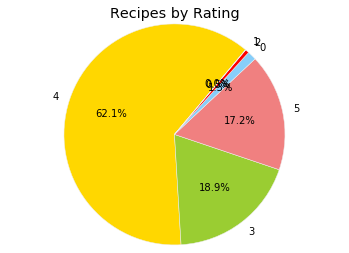

In [249]:
labels = ['4', '3', '5', '0', '2', '1']
plt.pie(cuisines.rating.value_counts(), labels=labels, autopct='%1.1f%%', colors=['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red'], startangle=50, pctdistance=0.6)
plt.axis('equal')
plt.title('Recipes by Rating')
plt.show()

In [240]:
graphlab.canvas.set_target('ipynb')
cuisine_new.show(view="Bar Chart", x="cuisine_label", y="recipe_label")

In [250]:
cuisine_new.show(view="Scatter Plot", x="rating", y="ingred_count")

In [243]:
cuisine_new.show(view="Scatter Plot", x="rating", y="totalTimeInSeconds")

In [94]:
cuisine_new.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]
